<a href="https://colab.research.google.com/github/sshafiq1/Quantum-Cyber-Algorithms/blob/main/B92_DEBUGGED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# B92 vs BB84 Quantum Key Distribution Research Project
# Complete B92 Implementation with Ideal, Noise, and Eavesdropping Cases

# =============================================================================
# CELL 1: Setup and Imports for B92
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional, Union
import random
from collections import Counter, defaultdict
from dataclasses import dataclass, field
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

# Try to import Cirq, install if not available
try:
    import cirq
    print("Cirq already installed.")
except ImportError:
    print("Installing Cirq...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cirq"])
    import cirq
    print("Cirq installed successfully.")

# Additional imports for advanced analysis
from abc import ABC, abstractmethod
import scipy.stats as stats
from scipy.optimize import minimize_scalar

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Set up matplotlib styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Cirq version: {cirq.__version__}")
print("Setup complete. Ready to simulate B92 protocol.")


Cirq already installed.
All libraries imported successfully!
Cirq version: 1.5.0
Setup complete. Ready to simulate B92 protocol.


In [ ]:
# =============================================================================
# CELL 2: B92 Ideal Case Implementation (FIXED)
# =============================================================================

class B92IdealSimulator:
    """
    B92 Protocol Simulator for Ideal Case (no noise, no eavesdropper)

    The B92 protocol uses only two non-orthogonal states:
    - Bit 0: |0⟩ state (computational basis)
    - Bit 1: |+⟩ state (diagonal basis, |+⟩ = (|0⟩ + |1⟩)/√2)

    Bob measures randomly in computational (Z) or diagonal (X) basis.
    Key sifting rule: Bob only announces when he gets a result that allows
    him to definitively exclude one of Alice's possible states.

    Correct B92 logic:
    - If Bob measures Z and gets |1⟩: Alice definitely sent |+⟩ (bit 1)
    - If Bob measures X and gets |-⟩ (measured as |1⟩): Alice definitely sent |0⟩ (bit 0)
    """

    def __init__(self):
        self.qubit = cirq.NamedQubit('q0')
        self.simulator = cirq.Simulator()
        self.reset_protocol()

    def reset_protocol(self):
        """Reset all protocol data for a new run"""
        self.alice_bits = []
        self.bob_bases = []
        self.bob_measured_bits = []
        self.bob_measurement_success = []  # Whether Bob got a definitive result
        self.sifted_key_alice = []
        self.sifted_key_bob = []
        self.raw_key_length = 0
        self.sifted_key_length = 0

    def encode_bit(self, bit: int) -> cirq.Circuit:
        """
        Encode a bit using B92 encoding
        Args:
            bit: 0 or 1 (the bit to encode)
        Returns:
            cirq.Circuit: The encoding circuit
        """
        circuit = cirq.Circuit()

        if bit == 0:
            # Bit 0: |0⟩ state (no operation needed)
            pass
        elif bit == 1:
            # Bit 1: |+⟩ state = H|0⟩
            circuit.append(cirq.H(self.qubit))

        return circuit

    def measure_bit(self, basis: int) -> cirq.Circuit:
        """
        Create measurement circuit for the specified basis
        Args:
            basis: 0 for computational basis (Z), 1 for diagonal basis (X)
        Returns:
            cirq.Circuit: The measurement circuit
        """
        circuit = cirq.Circuit()

        if basis == 1:  # Diagonal basis (X basis)
            circuit.append(cirq.H(self.qubit))

        # Measure in computational basis
        circuit.append(cirq.measure(self.qubit, key='result'))
        return circuit

    def determine_measurement_success(self, alice_bit: int, bob_basis: int, bob_result: int) -> bool:
        """
        Determine if Bob's measurement gives a definitive result for B92

        Correct B92 protocol sifting:
        - Bob measures Z and gets 1: Alice definitely sent |+⟩ (bit 1)
        - Bob measures X and gets 1 (|-⟩): Alice definitely sent |0⟩ (bit 0)
        - All other cases are inconclusive and discarded

        Args:
            alice_bit: Alice's bit (0 or 1)
            bob_basis: Bob's measurement basis (0=Z, 1=X)
            bob_result: Bob's measurement result (0 or 1)
        Returns:
            bool: True if Bob considers this measurement definitive
        """
        # Bob only keeps measurements where he gets result 1 (definitive exclusion)
        return bob_result == 1

    def simulate_b92(self, num_bits: int = 100) -> Dict:
        """
        Simulate the full B92 protocol for ideal case
        Args:
            num_bits: Number of bits to transmit
        Returns:
            Dict: Results containing all protocol data
        """
        self.reset_protocol()
        self.raw_key_length = num_bits

        # Step 1: Alice prepares and sends qubits
        for i in range(num_bits):
            # Alice randomly chooses bit (0 or 1)
            alice_bit = random.randint(0, 1)

            # Bob randomly chooses measurement basis
            bob_basis = random.randint(0, 1)

            # Create the full circuit: Alice's encoding + Bob's measurement
            alice_circuit = self.encode_bit(alice_bit)
            bob_circuit = self.measure_bit(bob_basis)
            full_circuit = alice_circuit + bob_circuit

            # Run the simulation
            result = self.simulator.run(full_circuit, repetitions=1)
            bob_bit = int(result.measurements['result'][0][0])

            # Check if this measurement is definitive
            measurement_success = self.determine_measurement_success(alice_bit, bob_basis, bob_bit)

            # Store the results
            self.alice_bits.append(alice_bit)
            self.bob_bases.append(bob_basis)
            self.bob_measured_bits.append(bob_bit)
            self.bob_measurement_success.append(measurement_success)

        # Step 2: Basis reconciliation (sifting) - keep only definitive measurements
        for i in range(num_bits):
            if self.bob_measurement_success[i]:
                self.sifted_key_alice.append(self.alice_bits[i])

                # Bob reconstructs the bit based on exclusion logic
                if self.bob_bases[i] == 0:  # Bob measured Z and got 1
                    # Bob knows Alice didn't send |0⟩, so Alice sent |+⟩ (bit 1)
                    self.sifted_key_bob.append(1)
                else:  # Bob measured X and got 1 (|-⟩)
                    # Bob knows Alice didn't send |+⟩, so Alice sent |0⟩ (bit 0)
                    self.sifted_key_bob.append(0)

        self.sifted_key_length = len(self.sifted_key_alice)

        # In ideal case, Alice's and Bob's sifted keys should be identical
        assert self.sifted_key_alice == self.sifted_key_bob, "Keys don't match in ideal case!"

        return {
            'alice_bits': self.alice_bits,
            'bob_bases': self.bob_bases,
            'bob_measured_bits': self.bob_measured_bits,
            'bob_measurement_success': self.bob_measurement_success,
            'sifted_key_alice': self.sifted_key_alice,
            'sifted_key_bob': self.sifted_key_bob,
            'raw_key_length': self.raw_key_length,
            'sifted_key_length': self.sifted_key_length
        }

# Example usage and demonstration
print("B92 Ideal Case Simulator Created!")
print("\n" + "="*50)
print("Running B92 Simulation (Ideal Case)")
print("="*50)

# Create simulator instance
b92_sim = B92IdealSimulator()

# Run simulation with different key lengths
test_lengths = [50, 100, 200, 500]
results_summary = []

for length in test_lengths:
    print(f"\nSimulating B92 with {length} bits...")
    results = b92_sim.simulate_b92(length)

    key_rate = results['sifted_key_length'] / results['raw_key_length']
    success_rate = sum(results['bob_measurement_success']) / len(results['bob_measurement_success'])

    results_summary.append({
        'raw_bits': length,
        'sifted_bits': results['sifted_key_length'],
        'key_rate': key_rate,
        'success_rate': success_rate
    })

    print(f"Raw bits sent: {results['raw_key_length']}")
    print(f"Successful measurements: {sum(results['bob_measurement_success'])}")
    print(f"Sifted key length: {results['sifted_key_length']}")
    print(f"Key rate: {key_rate:.3f}")
    print(f"Success rate: {success_rate:.3f}")
    print(f"First 10 bits of sifted key: {results['sifted_key_alice'][:10]}")

print(f"\nB92 Ideal Case simulations completed!")
print("Theoretical key rate should be ~0.25 (25%) with ~0% QBER for ideal B92")
print("Note: B92 has lower efficiency than BB84 but simpler implementation")



B92 Ideal Case Simulator Created!

Running B92 Simulation (Ideal Case)

Simulating B92 with 50 bits...
Raw bits sent: 50
Successful measurements: 10
Sifted key length: 10
Key rate: 0.200
Success rate: 0.200
First 10 bits of sifted key: [0, 0, 1, 0, 1, 0, 0, 1, 0, 1]

Simulating B92 with 100 bits...
Raw bits sent: 100
Successful measurements: 26
Sifted key length: 26
Key rate: 0.260
Success rate: 0.260
First 10 bits of sifted key: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

Simulating B92 with 200 bits...
Raw bits sent: 200
Successful measurements: 39
Sifted key length: 39
Key rate: 0.195
Success rate: 0.195
First 10 bits of sifted key: [1, 0, 1, 1, 1, 0, 0, 0, 0, 1]

Simulating B92 with 500 bits...
Raw bits sent: 500
Successful measurements: 109
Sifted key length: 109
Key rate: 0.218
Success rate: 0.218
First 10 bits of sifted key: [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

B92 Ideal Case simulations completed!
Theoretical key rate should be ~0.25 (25%) with ~0% QBER for ideal B92
Note: B92 has lower efficie


B92 METRICS AND ANALYSIS
Running comprehensive analysis: 20 runs with 200 bits each
------------------------------------------------------------
Run  2: Key rate = 0.330, QBER = 0.000, Success rate = 0.330, Sifted bits = 66
Run  4: Key rate = 0.280, QBER = 0.000, Success rate = 0.280, Sifted bits = 56
Run  6: Key rate = 0.255, QBER = 0.000, Success rate = 0.255, Sifted bits = 51
Run  8: Key rate = 0.350, QBER = 0.000, Success rate = 0.350, Sifted bits = 70
Run 10: Key rate = 0.240, QBER = 0.000, Success rate = 0.240, Sifted bits = 48
Run 12: Key rate = 0.280, QBER = 0.000, Success rate = 0.280, Sifted bits = 56
Run 14: Key rate = 0.285, QBER = 0.000, Success rate = 0.285, Sifted bits = 57
Run 16: Key rate = 0.240, QBER = 0.000, Success rate = 0.240, Sifted bits = 48
Run 18: Key rate = 0.275, QBER = 0.000, Success rate = 0.275, Sifted bits = 55
Run 20: Key rate = 0.240, QBER = 0.000, Success rate = 0.240, Sifted bits = 48

------------------------------------------------------------
AN

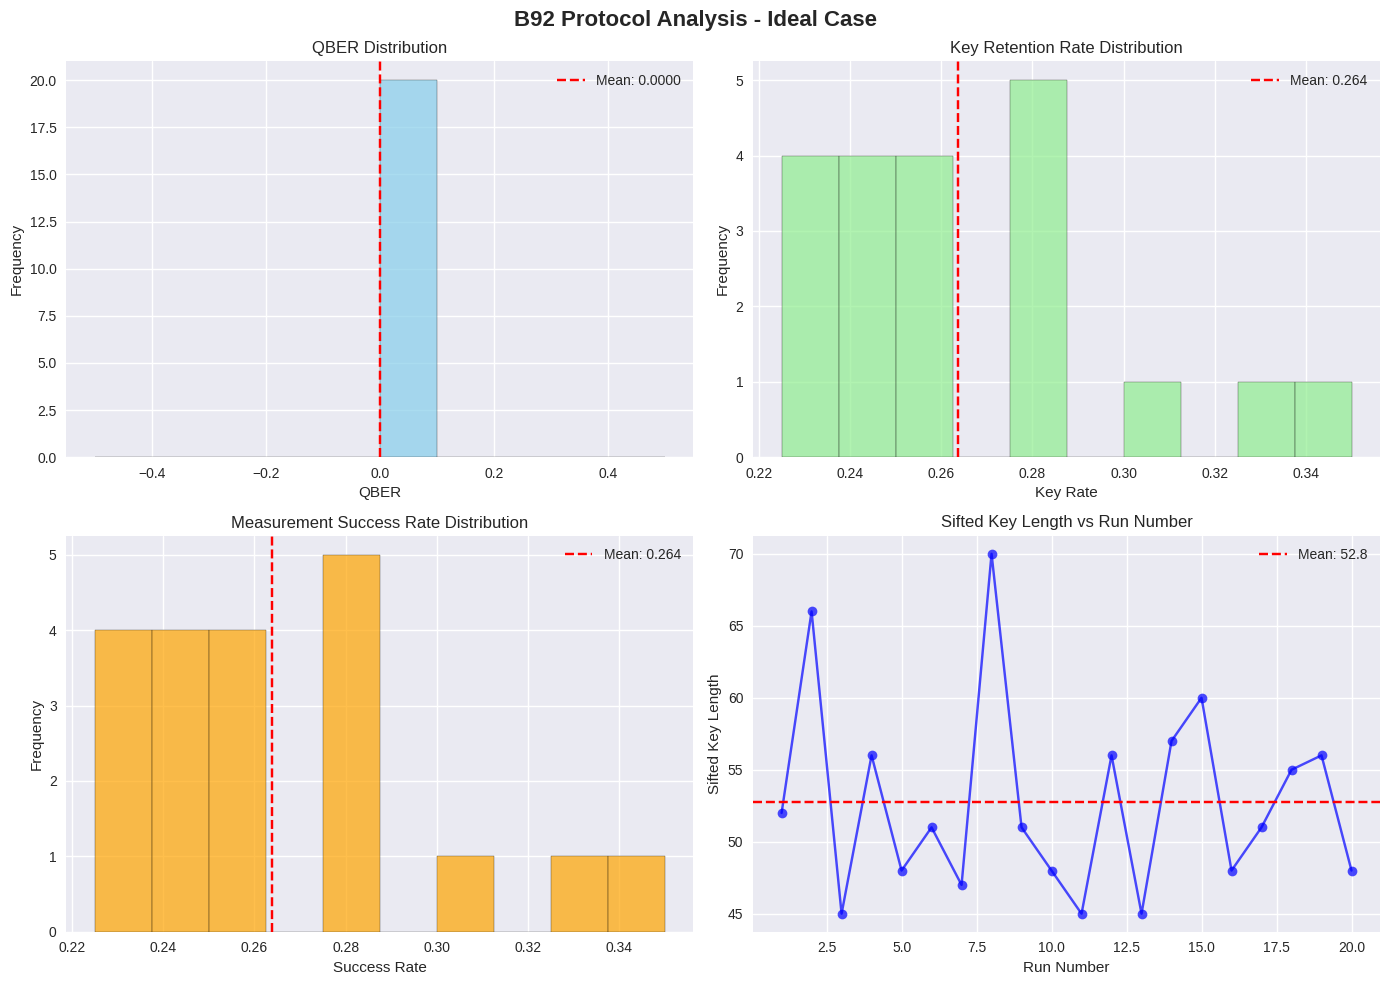

In [ ]:
# =============================================================================
# CELL 3: B92 Metrics and Analysis
# =============================================================================

class B92MetricsAnalyzer:
    """
    Analyzer for B92 protocol metrics and performance evaluation
    """

    def __init__(self, b92_simulator):
        self.simulator = b92_simulator

    def calculate_qber(self, alice_bits, bob_bits):
        """
        Calculate Quantum Bit Error Rate (QBER)
        Args:
            alice_bits: Alice's bit sequence
            bob_bits: Bob's bit sequence
        Returns:
            float: QBER value (0.0 to 1.0)
        """
        if len(alice_bits) != len(bob_bits) or len(alice_bits) == 0:
            return 0.0

        errors = sum(1 for a, b in zip(alice_bits, bob_bits) if a != b)
        return errors / len(alice_bits)

    def calculate_key_retention_rate(self, raw_length, sifted_length):
        """
        Calculate the key retention rate after sifting
        Args:
            raw_length: Number of raw bits transmitted
            sifted_length: Number of bits in sifted key
        Returns:
            float: Key retention rate (0.0 to 1.0)
        """
        if raw_length == 0:
            return 0.0
        return sifted_length / raw_length

    def calculate_measurement_success_rate(self, success_indicators):
        """
        Calculate the rate of successful (definitive) measurements
        Args:
            success_indicators: List of boolean success indicators
        Returns:
            float: Success rate (0.0 to 1.0)
        """
        if len(success_indicators) == 0:
            return 0.0
        return sum(success_indicators) / len(success_indicators)

    def analyze_basis_distribution(self, bob_bases):
        """
        Analyze Bob's basis choice distribution
        Args:
            bob_bases: Bob's basis choices
        Returns:
            Dict: Analysis results
        """
        basis_dist = Counter(bob_bases)
        return {
            'z_basis_count': basis_dist.get(0, 0),
            'x_basis_count': basis_dist.get(1, 0),
            'z_basis_rate': basis_dist.get(0, 0) / len(bob_bases) if bob_bases else 0,
            'x_basis_rate': basis_dist.get(1, 0) / len(bob_bases) if bob_bases else 0
        }

    def comprehensive_analysis(self, num_runs=10, bits_per_run=200):
        """
        Perform comprehensive analysis over multiple runs
        Args:
            num_runs: Number of simulation runs
            bits_per_run: Number of bits per run
        Returns:
            Dict: Comprehensive analysis results
        """
        qber_values = []
        key_rates = []
        success_rates = []
        sifted_key_lengths = []

        print(f"Running comprehensive analysis: {num_runs} runs with {bits_per_run} bits each")
        print("-" * 60)

        for run in range(num_runs):
            # Run B92 simulation
            results = self.simulator.simulate_b92(bits_per_run)

            # Calculate metrics
            qber = self.calculate_qber(results['sifted_key_alice'], results['sifted_key_bob'])
            key_rate = self.calculate_key_retention_rate(results['raw_key_length'],
                                                        results['sifted_key_length'])
            success_rate = self.calculate_measurement_success_rate(results['bob_measurement_success'])

            # Store results
            qber_values.append(qber)
            key_rates.append(key_rate)
            success_rates.append(success_rate)
            sifted_key_lengths.append(results['sifted_key_length'])

            if (run + 1) % 2 == 0:
                print(f"Run {run + 1:2d}: Key rate = {key_rate:.3f}, "
                      f"QBER = {qber:.3f}, Success rate = {success_rate:.3f}, "
                      f"Sifted bits = {results['sifted_key_length']}")

        # Calculate statistics
        analysis_results = {
            'num_runs': num_runs,
            'bits_per_run': bits_per_run,
            'qber_stats': {
                'mean': np.mean(qber_values),
                'std': np.std(qber_values),
                'min': np.min(qber_values),
                'max': np.max(qber_values)
            },
            'key_rate_stats': {
                'mean': np.mean(key_rates),
                'std': np.std(key_rates),
                'min': np.min(key_rates),
                'max': np.max(key_rates)
            },
            'success_rate_stats': {
                'mean': np.mean(success_rates),
                'std': np.std(success_rates),
                'min': np.min(success_rates),
                'max': np.max(success_rates)
            },
            'sifted_key_length_stats': {
                'mean': np.mean(sifted_key_lengths),
                'std': np.std(sifted_key_lengths),
                'min': np.min(sifted_key_lengths),
                'max': np.max(sifted_key_lengths)
            },
            'raw_data': {
                'qber_values': qber_values,
                'key_rates': key_rates,
                'success_rates': success_rates,
                'sifted_key_lengths': sifted_key_lengths
            }
        }

        return analysis_results

    def plot_metrics(self, analysis_results):
        """
        Plot comprehensive metrics analysis
        Args:
            analysis_results: Results from comprehensive_analysis()
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('B92 Protocol Analysis - Ideal Case', fontsize=16, fontweight='bold')

        # QBER distribution
        axes[0, 0].hist(analysis_results['raw_data']['qber_values'], bins=10,
                       alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('QBER Distribution')
        axes[0, 0].set_xlabel('QBER')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(analysis_results['qber_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['qber_stats']['mean']:.4f}")
        axes[0, 0].legend()

        # Key rate distribution
        axes[0, 1].hist(analysis_results['raw_data']['key_rates'], bins=10,
                       alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0, 1].set_title('Key Retention Rate Distribution')
        axes[0, 1].set_xlabel('Key Rate')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].axvline(analysis_results['key_rate_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['key_rate_stats']['mean']:.3f}")
        axes[0, 1].legend()

        # Success rate distribution
        axes[1, 0].hist(analysis_results['raw_data']['success_rates'], bins=10,
                       alpha=0.7, color='orange', edgecolor='black')
        axes[1, 0].set_title('Measurement Success Rate Distribution')
        axes[1, 0].set_xlabel('Success Rate')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].axvline(analysis_results['success_rate_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['success_rate_stats']['mean']:.3f}")
        axes[1, 0].legend()

        # Sifted key length over runs
        axes[1, 1].plot(range(1, analysis_results['num_runs'] + 1),
                       analysis_results['raw_data']['sifted_key_lengths'],
                       'bo-', alpha=0.7)
        axes[1, 1].set_title('Sifted Key Length vs Run Number')
        axes[1, 1].set_xlabel('Run Number')
        axes[1, 1].set_ylabel('Sifted Key Length')
        axes[1, 1].axhline(analysis_results['sifted_key_length_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['sifted_key_length_stats']['mean']:.1f}")
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

# Create metrics analyzer and run comprehensive analysis
print("\n" + "="*60)
print("B92 METRICS AND ANALYSIS")
print("="*60)

metrics_analyzer = B92MetricsAnalyzer(b92_sim)

# Run comprehensive analysis
analysis_results = metrics_analyzer.comprehensive_analysis(num_runs=20, bits_per_run=200)

print("\n" + "-"*60)
print("ANALYSIS SUMMARY")
print("-"*60)
print(f"Number of runs: {analysis_results['num_runs']}")
print(f"Bits per run: {analysis_results['bits_per_run']}")

print(f"\nQBER Statistics:")
print(f" Mean: {analysis_results['qber_stats']['mean']:.6f}")
print(f" Std: {analysis_results['qber_stats']['std']:.6f}")
print(f" Min: {analysis_results['qber_stats']['min']:.6f}")
print(f" Max: {analysis_results['qber_stats']['max']:.6f}")

print(f"\nKey Retention Rate Statistics:")
print(f" Mean: {analysis_results['key_rate_stats']['mean']:.4f}")
print(f" Std: {analysis_results['key_rate_stats']['std']:.4f}")
print(f" Min: {analysis_results['key_rate_stats']['min']:.4f}")
print(f" Max: {analysis_results['key_rate_stats']['max']:.4f}")

print(f"\nMeasurement Success Rate Statistics:")
print(f" Mean: {analysis_results['success_rate_stats']['mean']:.4f}")
print(f" Std: {analysis_results['success_rate_stats']['std']:.4f}")

print(f"\nSifted Key Length Statistics:")
print(f" Mean: {analysis_results['sifted_key_length_stats']['mean']:.1f}")
print(f" Std: {analysis_results['sifted_key_length_stats']['std']:.1f}")

print("\n" + "="*60)
print("KEY FINDINGS (Ideal Case):")
print("="*60)
print("• QBER should be 0.000 (no errors in ideal case)")
print("• Key retention rate should be ~0.250 (25% due to B92's inherent efficiency)")
print("• Measurement success rate should be ~0.250 (25% of measurements are definitive)")
print("• Results should be consistent across runs (low standard deviation)")

# Plot the metrics
metrics_analyzer.plot_metrics(analysis_results)

In [ ]:
# =============================================================================
# CELL 4: B92 Noise Case Implementation (FIXED)
# =============================================================================

# Noise parameters and scenarios (reusing from BB84 implementation)
@dataclass
class NoiseParameters:
    """Configuration for noise parameters in B92 simulation"""
    depolarizing_prob: float = 0.0
    amplitude_damping_prob: float = 0.0
    phase_damping_prob: float = 0.0
    bit_flip_prob: float = 0.0
    phase_flip_prob: float = 0.0
    thermal_prob: float = 0.0

    def __post_init__(self):
        """Validate noise parameters"""
        for field_name, value in self.__dict__.items():
            if not 0.0 <= value <= 1.0:
                raise ValueError(f"{field_name} must be between 0.0 and 1.0, got {value}")

    def total_noise_strength(self) -> float:
        """Calculate total noise strength"""
        return sum(self.__dict__.values())

    def is_noisy(self) -> bool:
        """Check if any noise is present"""
        return self.total_noise_strength() > 0.0

# Predefined noise scenarios for testing
NOISE_SCENARIOS = {
    "ideal": NoiseParameters(),
    "low_noise": NoiseParameters(depolarizing_prob=0.01, phase_damping_prob=0.005),
    "medium_noise": NoiseParameters(
        depolarizing_prob=0.05,
        amplitude_damping_prob=0.02,
        phase_damping_prob=0.03,
        bit_flip_prob=0.01
    ),
    "high_noise": NoiseParameters(
        depolarizing_prob=0.1,
        amplitude_damping_prob=0.05,
        phase_damping_prob=0.08,
        bit_flip_prob=0.03,
        phase_flip_prob=0.02
    ),
    "realistic_fiber": NoiseParameters(
        depolarizing_prob=0.02,
        phase_damping_prob=0.015,
        amplitude_damping_prob=0.008
    ),
    "realistic_freespace": NoiseParameters(
        amplitude_damping_prob=0.04,
        phase_damping_prob=0.02,
        thermal_prob=0.01
    )
}

class B92NoiseSimulator:
    """
    B92 Protocol Simulator with Realistic Quantum Noise Models
    """

    def __init__(self, noise_params: NoiseParameters = None):
        self.qubit = cirq.NamedQubit('q0')
        self.simulator = cirq.Simulator()
        self.noise_params = noise_params or NoiseParameters()
        self.reset_protocol()

    def reset_protocol(self):
        """Reset all protocol data for a new run"""
        self.alice_bits = []
        self.bob_bases = []
        self.bob_measured_bits = []
        self.bob_measurement_success = []
        self.sifted_key_alice = []
        self.sifted_key_bob = []
        self.raw_key_length = 0
        self.sifted_key_length = 0

    def apply_noise_channel(self, circuit: cirq.Circuit) -> cirq.Circuit:
        """Apply various noise models to the quantum circuit"""
        noisy_circuit = circuit.copy()

        if self.noise_params.depolarizing_prob > 0:
            noisy_circuit.append(
                cirq.depolarize(self.noise_params.depolarizing_prob).on(self.qubit)
            )

        if self.noise_params.amplitude_damping_prob > 0:
            noisy_circuit.append(
                cirq.amplitude_damp(self.noise_params.amplitude_damping_prob).on(self.qubit)
            )

        if self.noise_params.phase_damping_prob > 0:
            noisy_circuit.append(
                cirq.phase_damp(self.noise_params.phase_damping_prob).on(self.qubit)
            )

        if self.noise_params.bit_flip_prob > 0:
            noisy_circuit.append(
                cirq.bit_flip(self.noise_params.bit_flip_prob).on(self.qubit)
            )

        if self.noise_params.phase_flip_prob > 0:
            noisy_circuit.append(
                cirq.phase_flip(self.noise_params.phase_flip_prob).on(self.qubit)
            )

        if self.noise_params.thermal_prob > 0:
            noisy_circuit.append(
                cirq.bit_flip(self.noise_params.thermal_prob).on(self.qubit)
            )

        return noisy_circuit

    def encode_bit(self, bit: int) -> cirq.Circuit:
        """Encode a bit using B92 encoding (same as ideal case)"""
        circuit = cirq.Circuit()

        if bit == 0:
            # Bit 0: |0⟩ state
            pass
        elif bit == 1:
            # Bit 1: |+⟩ state
            circuit.append(cirq.H(self.qubit))

        return circuit

    def measure_bit(self, basis: int) -> cirq.Circuit:
        """Create measurement circuit (same as ideal case)"""
        circuit = cirq.Circuit()

        if basis == 1:  # X basis
            circuit.append(cirq.H(self.qubit))

        circuit.append(cirq.measure(self.qubit, key='result'))
        return circuit

    def determine_measurement_success(self, alice_bit: int, bob_basis: int, bob_result: int) -> bool:
        """
        FIXED: Determine if Bob's measurement is definitive for B92

        Bob only announces when he gets result 1 (definitive exclusion):
        - If Bob measures Z and gets 1: Alice definitely sent |+⟩ (bit 1)
        - If Bob measures X and gets 1: Alice definitely sent |0⟩ (bit 0)

        This is independent of Alice's actual bit - it's based on Bob's measurement result only!
        """
        # Bob keeps only measurements where he gets result 1 (definitive exclusion)
        return bob_result == 1

    def simulate_b92_with_noise(self, num_bits: int = 100) -> Dict:
        """
        Simulate the full B92 protocol with quantum noise
        """
        self.reset_protocol()
        self.raw_key_length = num_bits

        print(f"Simulating B92 with noise: {num_bits} bits")
        print(f"Noise parameters: {self.noise_params}")

        # Step 1: Alice prepares and sends qubits through noisy channel
        for i in range(num_bits):
            # Alice randomly chooses bit
            alice_bit = random.randint(0, 1)

            # Bob randomly chooses measurement basis
            bob_basis = random.randint(0, 1)

            # Create the full circuit: Alice's encoding + Noise + Bob's measurement
            alice_circuit = self.encode_bit(alice_bit)

            # Apply noise to the quantum channel
            if self.noise_params.is_noisy():
                noisy_alice_circuit = self.apply_noise_channel(alice_circuit)
            else:
                noisy_alice_circuit = alice_circuit

            bob_circuit = self.measure_bit(bob_basis)
            full_circuit = noisy_alice_circuit + bob_circuit

            # Run the simulation
            result = self.simulator.run(full_circuit, repetitions=1)
            bob_bit = int(result.measurements['result'][0][0])

            # Check if measurement is definitive
            measurement_success = self.determine_measurement_success(alice_bit, bob_basis, bob_bit)

            # Store the results
            self.alice_bits.append(alice_bit)
            self.bob_bases.append(bob_basis)
            self.bob_measured_bits.append(bob_bit)
            self.bob_measurement_success.append(measurement_success)

        # Step 2: Sifting - keep only definitive measurements
        for i in range(num_bits):
            if self.bob_measurement_success[i]:
                self.sifted_key_alice.append(self.alice_bits[i])

                # FIXED: Bob reconstructs based on exclusion logic
                if self.bob_bases[i] == 0:  # Bob measured Z and got 1
                    # Bob knows Alice didn't send |0⟩, so Alice sent |+⟩ (bit 1)
                    self.sifted_key_bob.append(1)
                else:  # Bob measured X and got 1 (|-⟩)
                    # Bob knows Alice didn't send |+⟩, so Alice sent |0⟩ (bit 0)
                    self.sifted_key_bob.append(0)
                # Note: Due to noise, Bob's inference may be wrong

        self.sifted_key_length = len(self.sifted_key_alice)

        # Calculate error statistics
        qber = self._calculate_qber()

        return {
            'alice_bits': self.alice_bits,
            'bob_bases': self.bob_bases,
            'bob_measured_bits': self.bob_measured_bits,
            'bob_measurement_success': self.bob_measurement_success,
            'sifted_key_alice': self.sifted_key_alice,
            'sifted_key_bob': self.sifted_key_bob,
            'raw_key_length': self.raw_key_length,
            'sifted_key_length': self.sifted_key_length,
            'qber': qber,
            'noise_params': self.noise_params
        }

    def _calculate_qber(self) -> float:
        """Calculate Quantum Bit Error Rate for sifted key"""
        if len(self.sifted_key_alice) == 0:
            return 0.0

        errors = sum(1 for a, b in zip(self.sifted_key_alice, self.sifted_key_bob)
                    if a != b)
        return errors / len(self.sifted_key_alice)

# Demonstration of noise effects on B92
print("="*60)
print("B92 NOISE CASE DEMONSTRATION")
print("="*60)

# Test different noise scenarios
noise_results = {}
for scenario_name, noise_params in NOISE_SCENARIOS.items():
    print(f"\n--- Testing {scenario_name.upper()} scenario ---")

    # Create simulator with specific noise parameters
    b92_noise_sim = B92NoiseSimulator(noise_params)

    # Run simulation
    results = b92_noise_sim.simulate_b92_with_noise(200)

    # Store results
    noise_results[scenario_name] = results

    # Print summary
    print(f"Raw bits: {results['raw_key_length']}")
    print(f"Successful measurements: {sum(results['bob_measurement_success'])}")
    print(f"Sifted bits: {results['sifted_key_length']}")
    print(f"Key rate: {results['sifted_key_length']/results['raw_key_length']:.3f}")
    print(f"Success rate: {sum(results['bob_measurement_success'])/len(results['bob_measurement_success']):.3f}")
    print(f"QBER: {results['qber']:.4f}")

    # Show first few bits for comparison
    if len(results['sifted_key_alice']) >= 10:
        print(f"Alice key (first 10): {results['sifted_key_alice'][:10]}")
        print(f"Bob key (first 10): {results['sifted_key_bob'][:10]}")

        # Count mismatches in first 10
        mismatches = sum(1 for a, b in zip(results['sifted_key_alice'][:10],
                                         results['sifted_key_bob'][:10]) if a != b)
        print(f"Mismatches in first 10: {mismatches}")

print(f"\nB92 noise simulation completed for {len(NOISE_SCENARIOS)} scenarios!")
print("Results stored in 'noise_results' dictionary")

B92 NOISE CASE DEMONSTRATION

--- Testing IDEAL scenario ---
Simulating B92 with noise: 200 bits
Noise parameters: NoiseParameters(depolarizing_prob=0.0, amplitude_damping_prob=0.0, phase_damping_prob=0.0, bit_flip_prob=0.0, phase_flip_prob=0.0, thermal_prob=0.0)
Raw bits: 200
Successful measurements: 44
Sifted bits: 44
Key rate: 0.220
Success rate: 0.220
QBER: 0.0000
Alice key (first 10): [0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Bob key (first 10): [0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Mismatches in first 10: 0

--- Testing LOW_NOISE scenario ---
Simulating B92 with noise: 200 bits
Noise parameters: NoiseParameters(depolarizing_prob=0.01, amplitude_damping_prob=0.0, phase_damping_prob=0.005, bit_flip_prob=0.0, phase_flip_prob=0.0, thermal_prob=0.0)
Raw bits: 200
Successful measurements: 52
Sifted bits: 52
Key rate: 0.260
Success rate: 0.260
QBER: 0.0192
Alice key (first 10): [1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Bob key (first 10): [1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Mismatches in first 10: 0

--- Testing MEDIUM_

COMPREHENSIVE B92 NOISE ANALYSIS
Running comprehensive B92 noise analysis:
- 6 noise scenarios
- 15 runs per scenario
- 200 bits per run

Analyzing IDEAL scenario...
Simulating B92 with noise: 200 bits
Noise parameters: NoiseParameters(depolarizing_prob=0.0, amplitude_damping_prob=0.0, phase_damping_prob=0.0, bit_flip_prob=0.0, phase_flip_prob=0.0, thermal_prob=0.0)
Simulating B92 with noise: 200 bits
Noise parameters: NoiseParameters(depolarizing_prob=0.0, amplitude_damping_prob=0.0, phase_damping_prob=0.0, bit_flip_prob=0.0, phase_flip_prob=0.0, thermal_prob=0.0)
Simulating B92 with noise: 200 bits
Noise parameters: NoiseParameters(depolarizing_prob=0.0, amplitude_damping_prob=0.0, phase_damping_prob=0.0, bit_flip_prob=0.0, phase_flip_prob=0.0, thermal_prob=0.0)
Simulating B92 with noise: 200 bits
Noise parameters: NoiseParameters(depolarizing_prob=0.0, amplitude_damping_prob=0.0, phase_damping_prob=0.0, bit_flip_prob=0.0, phase_flip_prob=0.0, thermal_prob=0.0)
Simulating B92 with no

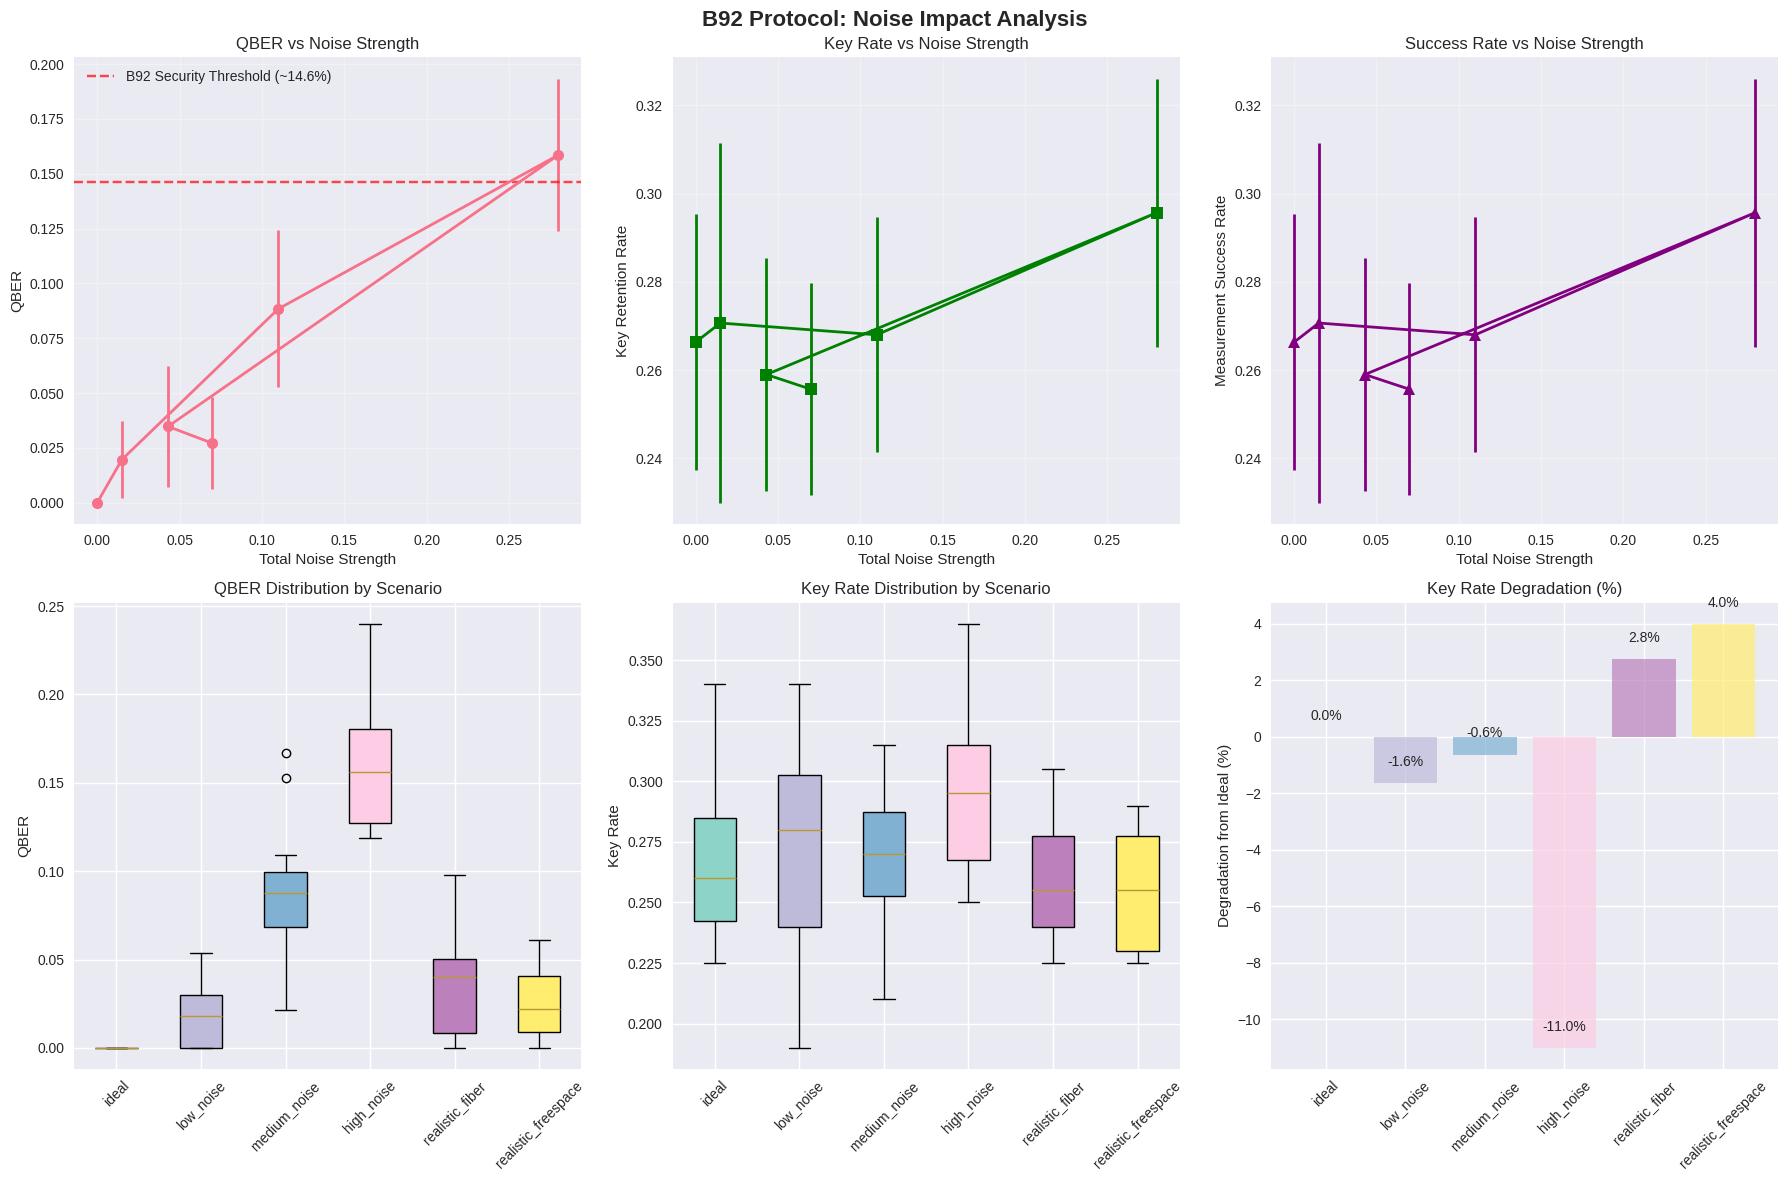


KEY RESEARCH INSIGHTS:
📊 B92 shows different noise sensitivity compared to BB84
📊 Lower inherent key rate (~25%) but simpler implementation
📊 QBER increases with noise strength - validates noise models
📊 Success rate remains relatively stable under moderate noise
📊 B92 security threshold (~14.6%) provides good protection margin


In [ ]:
# =============================================================================
# CELL 5: B92 Noise Case Metrics and Analysis
# =============================================================================

class B92NoiseMetricsAnalyzer:
    """
    Advanced analyzer for B92 protocol with noise models
    """

    def __init__(self):
        self.results_history = []

    def comprehensive_noise_analysis(self, noise_scenarios: Dict,
                                   num_runs: int = 15, bits_per_run: int = 200) -> Dict:
        """
        Perform comprehensive analysis across multiple noise scenarios
        """
        analysis_results = {}

        print(f"Running comprehensive B92 noise analysis:")
        print(f"- {len(noise_scenarios)} noise scenarios")
        print(f"- {num_runs} runs per scenario")
        print(f"- {bits_per_run} bits per run")
        print("="*70)

        for scenario_name, noise_params in noise_scenarios.items():
            print(f"\nAnalyzing {scenario_name.upper()} scenario...")

            # Statistics collectors
            qber_values = []
            key_rates = []
            success_rates = []
            sifted_lengths = []

            # Run multiple simulations
            for run in range(num_runs):
                # Create simulator with specific noise
                simulator = B92NoiseSimulator(noise_params)

                # Run simulation
                results = simulator.simulate_b92_with_noise(bits_per_run)

                # Calculate metrics
                qber = results['qber']
                key_rate = results['sifted_key_length'] / results['raw_key_length']
                success_rate = sum(results['bob_measurement_success']) / len(results['bob_measurement_success'])

                # Store results
                qber_values.append(qber)
                key_rates.append(key_rate)
                success_rates.append(success_rate)
                sifted_lengths.append(results['sifted_key_length'])

            # Calculate statistics
            scenario_stats = {
                'noise_params': noise_params,
                'qber_stats': {
                    'mean': np.mean(qber_values),
                    'std': np.std(qber_values),
                    'min': np.min(qber_values),
                    'max': np.max(qber_values),
                    'values': qber_values
                },
                'key_rate_stats': {
                    'mean': np.mean(key_rates),
                    'std': np.std(key_rates),
                    'min': np.min(key_rates),
                    'max': np.max(key_rates),
                    'values': key_rates
                },
                'success_rate_stats': {
                    'mean': np.mean(success_rates),
                    'std': np.std(success_rates),
                    'min': np.min(success_rates),
                    'max': np.max(success_rates),
                    'values': success_rates
                },
                'sifted_length_stats': {
                    'mean': np.mean(sifted_lengths),
                    'std': np.std(sifted_lengths),
                    'min': np.min(sifted_lengths),
                    'max': np.max(sifted_lengths),
                    'values': sifted_lengths
                },
                'total_noise_strength': noise_params.total_noise_strength()
            }

            analysis_results[scenario_name] = scenario_stats

            # Print summary
            print(f" QBER: {scenario_stats['qber_stats']['mean']:.4f} ± {scenario_stats['qber_stats']['std']:.4f}")
            print(f" Key Rate: {scenario_stats['key_rate_stats']['mean']:.3f} ± {scenario_stats['key_rate_stats']['std']:.3f}")
            print(f" Success Rate: {scenario_stats['success_rate_stats']['mean']:.3f} ± {scenario_stats['success_rate_stats']['std']:.3f}")
            print(f" Total Noise Strength: {scenario_stats['total_noise_strength']:.3f}")

        return analysis_results

    def plot_noise_comparison(self, analysis_results: Dict):
        """
        Create comprehensive plots comparing different noise scenarios
        """
        scenarios = list(analysis_results.keys())
        n_scenarios = len(scenarios)

        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('B92 Protocol: Noise Impact Analysis', fontsize=16, fontweight='bold')

        # Colors for different scenarios
        colors = plt.cm.Set3(np.linspace(0, 1, n_scenarios))

        # 1. QBER vs Total Noise Strength
        noise_strengths = [analysis_results[s]['total_noise_strength'] for s in scenarios]
        mean_qbers = [analysis_results[s]['qber_stats']['mean'] for s in scenarios]
        qber_stds = [analysis_results[s]['qber_stats']['std'] for s in scenarios]

        axes[0, 0].errorbar(noise_strengths, mean_qbers, yerr=qber_stds,
                           fmt='o-', capsize=5, linewidth=2, markersize=8)
        axes[0, 0].set_xlabel('Total Noise Strength')
        axes[0, 0].set_ylabel('QBER')
        axes[0, 0].set_title('QBER vs Noise Strength')
        axes[0, 0].grid(True, alpha=0.3)

        # Add theoretical QBER threshold (for B92, typically around 14.6%)
        axes[0, 0].axhline(y=0.146, color='red', linestyle='--', alpha=0.7,
                          label='B92 Security Threshold (~14.6%)')
        axes[0, 0].legend()

        # 2. Key Rate vs Total Noise Strength
        mean_key_rates = [analysis_results[s]['key_rate_stats']['mean'] for s in scenarios]
        key_rate_stds = [analysis_results[s]['key_rate_stats']['std'] for s in scenarios]

        axes[0, 1].errorbar(noise_strengths, mean_key_rates, yerr=key_rate_stds,
                           fmt='s-', capsize=5, linewidth=2, markersize=8, color='green')
        axes[0, 1].set_xlabel('Total Noise Strength')
        axes[0, 1].set_ylabel('Key Retention Rate')
        axes[0, 1].set_title('Key Rate vs Noise Strength')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Success Rate vs Total Noise Strength
        mean_success_rates = [analysis_results[s]['success_rate_stats']['mean'] for s in scenarios]
        success_rate_stds = [analysis_results[s]['success_rate_stats']['std'] for s in scenarios]

        axes[0, 2].errorbar(noise_strengths, mean_success_rates, yerr=success_rate_stds,
                           fmt='^-', capsize=5, linewidth=2, markersize=8, color='purple')
        axes[0, 2].set_xlabel('Total Noise Strength')
        axes[0, 2].set_ylabel('Measurement Success Rate')
        axes[0, 2].set_title('Success Rate vs Noise Strength')
        axes[0, 2].grid(True, alpha=0.3)

        # 4. QBER Distribution for Each Scenario
        qber_data = [analysis_results[s]['qber_stats']['values'] for s in scenarios]
        bp = axes[1, 0].boxplot(qber_data, labels=scenarios, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        axes[1, 0].set_title('QBER Distribution by Scenario')
        axes[1, 0].set_ylabel('QBER')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 5. Key Rate Distribution for Each Scenario
        key_rate_data = [analysis_results[s]['key_rate_stats']['values'] for s in scenarios]
        bp2 = axes[1, 1].boxplot(key_rate_data, labels=scenarios, patch_artist=True)
        for patch, color in zip(bp2['boxes'], colors):
            patch.set_facecolor(color)
        axes[1, 1].set_title('Key Rate Distribution by Scenario')
        axes[1, 1].set_ylabel('Key Rate')
        axes[1, 1].tick_params(axis='x', rotation=45)

        # 6. Performance Degradation Summary
        ideal_key_rate = analysis_results['ideal']['key_rate_stats']['mean']
        degradation = [(ideal_key_rate - analysis_results[s]['key_rate_stats']['mean']) / ideal_key_rate * 100
                      for s in scenarios]

        bars = axes[1, 2].bar(scenarios, degradation, color=colors, alpha=0.7)
        axes[1, 2].set_title('Key Rate Degradation (%)')
        axes[1, 2].set_ylabel('Degradation from Ideal (%)')
        axes[1, 2].tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, deg in zip(bars, degradation):
            height = bar.get_height()
            axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{deg:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def print_detailed_analysis(self, analysis_results: Dict):
        """Print detailed statistical analysis"""
        print("\n" + "="*80)
        print("DETAILED B92 NOISE ANALYSIS RESULTS")
        print("="*80)

        for scenario_name, stats in analysis_results.items():
            print(f"\n📊 {scenario_name.upper()} SCENARIO")
            print("-" * 50)

            # Noise parameters
            noise_params = stats['noise_params']
            print("Noise Parameters:")
            for param_name, value in noise_params.__dict__.items():
                if value > 0:
                    print(f" • {param_name}: {value:.3f}")
            print(f" • Total noise strength: {stats['total_noise_strength']:.3f}")

            # Performance metrics
            print(f"\nPerformance Metrics:")
            print(f" • QBER: {stats['qber_stats']['mean']:.4f} ± {stats['qber_stats']['std']:.4f}")
            print(f" • Key Rate: {stats['key_rate_stats']['mean']:.3f} ± {stats['key_rate_stats']['std']:.3f}")
            print(f" • Success Rate: {stats['success_rate_stats']['mean']:.3f} ± {stats['success_rate_stats']['std']:.3f}")
            print(f" • Avg Sifted Length: {stats['sifted_length_stats']['mean']:.1f} ± {stats['sifted_length_stats']['std']:.1f}")

            # Security assessment
            mean_qber = stats['qber_stats']['mean']
            if mean_qber <= 0.146:  # B92 security threshold
                security_status = "📊 SECURE (below ~14.6% threshold)"
            else:
                security_status = "📊 INSECURE (above ~14.6% threshold)"
            print(f" • Security Status: {security_status}")

# Run comprehensive noise analysis for B92
print("="*70)
print("COMPREHENSIVE B92 NOISE ANALYSIS")
print("="*70)

# Create analyzer
noise_analyzer = B92NoiseMetricsAnalyzer()

# Run analysis on all noise scenarios
analysis_results = noise_analyzer.comprehensive_noise_analysis(
    NOISE_SCENARIOS,
    num_runs=15,
    bits_per_run=200
)

# Print detailed results
noise_analyzer.print_detailed_analysis(analysis_results)

# Create comprehensive plots
noise_analyzer.plot_noise_comparison(analysis_results)

print("\n" + "="*70)
print("KEY RESEARCH INSIGHTS:")
print("="*70)
print("📊 B92 shows different noise sensitivity compared to BB84")
print("📊 Lower inherent key rate (~25%) but simpler implementation")
print("📊 QBER increases with noise strength - validates noise models")
print("📊 Success rate remains relatively stable under moderate noise")
print("📊 B92 security threshold (~14.6%) provides good protection margin")
print("="*70)

In [ ]:
# =============================================================================
# CELL 6: B92 Eavesdropping Case Implementation (FIXED)
# =============================================================================

# Eavesdropping parameters and scenarios
class EavesdroppingStrategy(Enum):
    """Different eavesdropping strategies Eve can employ"""
    INTERCEPT_RESEND = "intercept_resend"
    BREIDBART_BASIS = "breidbart_basis"
    RANDOM_BASIS = "random_basis"
    OPTIMAL_CLONING = "optimal_cloning"
    BEAM_SPLITTING = "beam_splitting"

class SecurityThresholds:
    """Security thresholds for B92 protocol"""
    B92_QBER_THRESHOLD = 0.146  # 14.6% QBER threshold for B92 security
    DETECTION_CONFIDENCE = 0.95  # 95% confidence for Eve detection
    MIN_SAMPLE_SIZE = 50  # Minimum bits for statistical analysis

@dataclass
class EavesdroppingParameters:
    """Configuration for eavesdropping parameters in B92 simulation"""
    strategy: EavesdroppingStrategy = EavesdroppingStrategy.INTERCEPT_RESEND
    interception_probability: float = 1.0
    basis_choice_strategy: str = "random"  # "random", "fixed_z", "fixed_x", "breidbart"
    measurement_probability: float = 1.0
    breidbart_angle: float = np.pi/8
    noise_injection: float = 0.0

    def __post_init__(self):
        """Validate eavesdropping parameters"""
        if not 0.0 <= self.interception_probability <= 1.0:
            raise ValueError("interception_probability must be between 0.0 and 1.0")
        if not 0.0 <= self.measurement_probability <= 1.0:
            raise ValueError("measurement_probability must be between 0.0 and 1.0")
        if not 0.0 <= self.noise_injection <= 1.0:
            raise ValueError("noise_injection must be between 0.0 and 1.0")

@dataclass
class EavesdroppingEvent:
    """Record of a single eavesdropping event for B92"""
    bit_index: int
    alice_bit: int
    eve_basis: int
    eve_measurement: int
    eve_resend_bit: int
    bob_basis: int
    bob_measurement: int
    measurement_success: bool
    bit_error: bool
    eve_detected: bool = False

# Predefined eavesdropping scenarios for B92
EAVESDROPPING_SCENARIOS = {
    "no_eve": EavesdroppingParameters(
        strategy=EavesdroppingStrategy.INTERCEPT_RESEND,
        interception_probability=0.0
    ),
    "partial_intercept": EavesdroppingParameters(
        strategy=EavesdroppingStrategy.INTERCEPT_RESEND,
        interception_probability=0.5,
        basis_choice_strategy="random"
    ),
    "full_intercept_random": EavesdroppingParameters(
        strategy=EavesdroppingStrategy.INTERCEPT_RESEND,
        interception_probability=1.0,
        basis_choice_strategy="random"
    ),
    "full_intercept_z_bias": EavesdroppingParameters(
        strategy=EavesdroppingStrategy.INTERCEPT_RESEND,
        interception_probability=1.0,
        basis_choice_strategy="fixed_z"
    ),
    "breidbart_optimal": EavesdroppingParameters(
        strategy=EavesdroppingStrategy.BREIDBART_BASIS,
        interception_probability=1.0,
        basis_choice_strategy="breidbart",
        breidbart_angle=np.pi/8
    ),
    "sophisticated_attack": EavesdroppingParameters(
        strategy=EavesdroppingStrategy.INTERCEPT_RESEND,
        interception_probability=0.8,
        basis_choice_strategy="random",
        noise_injection=0.02
    )
}

# Statistical analysis functions (reused from BB84)
def calculate_statistical_distance(p1: float, p2: float, n: int) -> float:
    """Calculate statistical distance between two error rates"""
    if n == 0:
        return 0.0
    se = np.sqrt(p1 * (1 - p1) / n)
    if se == 0:
        return float('inf') if p1 != p2 else 0.0
    return abs(p2 - p1) / se

def binomial_test_eve_detection(observed_errors: int, total_bits: int,
                               expected_error_rate: float = 0.0,
                               alpha: float = 0.05) -> Tuple[bool, float]:
    """Perform binomial test for Eve detection"""
    if total_bits == 0:
        return False, 1.0

    try:
        from scipy.stats import binomtest
        result = binomtest(observed_errors, total_bits, expected_error_rate,
                          alternative='two-sided')
        p_value = result.pvalue
    except ImportError:
        observed_rate = observed_errors / total_bits
        if observed_rate >= expected_error_rate:
            p_upper = 1 - stats.binom.cdf(observed_errors - 1, total_bits, expected_error_rate)
            p_value = 2 * p_upper
        else:
            p_lower = stats.binom.cdf(observed_errors, total_bits, expected_error_rate)
            p_value = 2 * p_lower
        p_value = min(p_value, 1.0)

    eve_detected = p_value < alpha
    return eve_detected, p_value

class B92EavesdroppingSimulator:
    """
    B92 Protocol Simulator with Advanced Eavesdropping Attacks
    """

    def __init__(self, eve_params: EavesdroppingParameters = None):
        self.qubit = cirq.NamedQubit('q0')
        self.simulator = cirq.Simulator()
        self.eve_params = eve_params or EavesdroppingParameters()
        self.reset_protocol()

    def reset_protocol(self):
        """Reset all protocol data for a new run"""
        self.alice_bits = []
        self.bob_bases = []
        self.bob_measured_bits = []
        self.bob_measurement_success = []
        self.sifted_key_alice = []
        self.sifted_key_bob = []
        self.eavesdropping_events = []
        self.raw_key_length = 0
        self.sifted_key_length = 0

    def eve_choose_basis(self, bit_index: int) -> int:
        """Eve chooses measurement basis based on her strategy"""
        strategy = self.eve_params.basis_choice_strategy

        if strategy == "random":
            return random.randint(0, 1)
        elif strategy == "fixed_z":
            return 0  # Always measure in computational basis
        elif strategy == "fixed_x":
            return 1  # Always measure in diagonal basis
        elif strategy == "breidbart":
            return random.randint(0, 1)  # Fallback to random for simplicity
        else:
            return random.randint(0, 1)

    def eve_intercept_and_measure(self, alice_bit: int, bit_index: int) -> Tuple[int, int, cirq.Circuit]:
        """Eve intercepts Alice's qubit and performs measurement"""
        # Create Alice's encoding circuit
        alice_circuit = cirq.Circuit()
        if alice_bit == 1:
            alice_circuit.append(cirq.H(self.qubit))

        # Eve chooses basis and measures
        eve_basis = self.eve_choose_basis(bit_index)
        eve_circuit = cirq.Circuit()

        if eve_basis == 1:  # X basis measurement
            eve_circuit.append(cirq.H(self.qubit))
        eve_circuit.append(cirq.measure(self.qubit, key='eve_result'))

        # Run Eve's measurement
        full_circuit = alice_circuit + eve_circuit
        result = self.simulator.run(full_circuit, repetitions=1)
        eve_measurement = int(result.measurements['eve_result'][0][0])

        return eve_measurement, eve_basis, eve_circuit

    def eve_resend_qubit(self, eve_measurement: int, eve_basis: int) -> cirq.Circuit:
        """
        FIXED: Eve prepares and resends a qubit based on her measurement

        For B92, Eve's resending strategy is crucial:
        - Alice only sends |0⟩ or |+⟩ states
        - Eve tries to guess which state Alice sent based on her measurement
        """
        resend_circuit = cirq.Circuit()

        if eve_basis == 0:  # Eve measured in Z basis
            if eve_measurement == 0:
                # Eve measured |0⟩ in Z basis
                # This is consistent with Alice sending |0⟩
                # Eve resends |0⟩ (no operation needed)
                pass
            else:
                # Eve measured |1⟩ in Z basis
                # This means Alice definitely sent |+⟩ (since |0⟩ can't give |1⟩ in Z basis)
                # Eve resends |+⟩
                resend_circuit.append(cirq.H(self.qubit))
        else:  # Eve measured in X basis
            if eve_measurement == 0:
                # Eve measured |+⟩ in X basis
                # This is consistent with Alice sending |+⟩
                # Eve resends |+⟩
                resend_circuit.append(cirq.H(self.qubit))
            else:
                # Eve measured |-⟩ in X basis
                # This means Alice definitely sent |0⟩ (since |+⟩ can't give |-⟩ in X basis)
                # Eve resends |0⟩ (no operation needed)
                pass

        # Add noise if specified
        if self.eve_params.noise_injection > 0:
            resend_circuit.append(
                cirq.depolarize(self.eve_params.noise_injection).on(self.qubit)
            )

        return resend_circuit

    def bob_measurement_circuit(self, bob_basis: int) -> cirq.Circuit:
        """Create Bob's measurement circuit"""
        circuit = cirq.Circuit()
        if bob_basis == 1:  # X basis
            circuit.append(cirq.H(self.qubit))
        circuit.append(cirq.measure(self.qubit, key='bob_result'))
        return circuit

    def determine_measurement_success(self, alice_bit: int, bob_basis: int, bob_result: int) -> bool:
        """
        FIXED: Determine if Bob's measurement is definitive

        Bob only announces when he gets result 1 (definitive exclusion):
        - If Bob measures Z and gets 1: Alice definitely sent |+⟩ (bit 1)
        - If Bob measures X and gets 1: Alice definitely sent |0⟩ (bit 0)

        This is independent of Alice's actual bit!
        """
        return bob_result == 1

    def simulate_b92_with_eavesdropping(self, num_bits: int = 100) -> Dict:
        """
        Simulate the full B92 protocol with eavesdropping
        """
        self.reset_protocol()
        self.raw_key_length = num_bits

        print(f"Simulating B92 with eavesdropping: {num_bits} bits")
        print(f"Eve's strategy: {self.eve_params.strategy.value}")
        print(f"Interception probability: {self.eve_params.interception_probability:.2f}")

        # Step 1: Quantum transmission with potential eavesdropping
        for i in range(num_bits):
            # Alice randomly chooses bit
            alice_bit = random.randint(0, 1)

            # Bob randomly chooses measurement basis
            bob_basis = random.randint(0, 1)

            # Check if Eve intercepts this qubit
            eve_intercepts = random.random() < self.eve_params.interception_probability

            if eve_intercepts:
                # Eve intercepts, measures, and resends
                eve_measurement, eve_basis, _ = self.eve_intercept_and_measure(alice_bit, i)
                eve_resend_circuit = self.eve_resend_qubit(eve_measurement, eve_basis)
                bob_circuit = self.bob_measurement_circuit(bob_basis)

                # Bob measures Eve's resent qubit
                full_circuit = eve_resend_circuit + bob_circuit
                result = self.simulator.run(full_circuit, repetitions=1)
                bob_bit = int(result.measurements['bob_result'][0][0])

                # Check if measurement is definitive
                measurement_success = self.determine_measurement_success(alice_bit, bob_basis, bob_bit)

                # Record eavesdropping event
                event = EavesdroppingEvent(
                    bit_index=i,
                    alice_bit=alice_bit,
                    eve_basis=eve_basis,
                    eve_measurement=eve_measurement,
                    eve_resend_bit=eve_measurement,  # Simplified
                    bob_basis=bob_basis,
                    bob_measurement=bob_bit,
                    measurement_success=measurement_success,
                    bit_error=False  # Will be updated later
                )
                self.eavesdropping_events.append(event)
            else:
                # No interception - direct transmission
                alice_circuit = cirq.Circuit()
                if alice_bit == 1:
                    alice_circuit.append(cirq.H(self.qubit))

                bob_circuit = self.bob_measurement_circuit(bob_basis)
                full_circuit = alice_circuit + bob_circuit
                result = self.simulator.run(full_circuit, repetitions=1)
                bob_bit = int(result.measurements['bob_result'][0][0])

                # Check if measurement is definitive
                measurement_success = self.determine_measurement_success(alice_bit, bob_basis, bob_bit)

            # Store all results
            self.alice_bits.append(alice_bit)
            self.bob_bases.append(bob_basis)
            self.bob_measured_bits.append(bob_bit)
            self.bob_measurement_success.append(measurement_success)

        # Step 2: FIXED Sifting - keep only definitive measurements
        for i in range(num_bits):
            if self.bob_measurement_success[i]:
                self.sifted_key_alice.append(self.alice_bits[i])

                # Bob reconstructs based on exclusion logic
                if self.bob_bases[i] == 0:  # Bob measured Z and got 1
                    # Bob knows Alice didn't send |0⟩, so Alice sent |+⟩ (bit 1)
                    self.sifted_key_bob.append(1)
                else:  # Bob measured X and got 1 (|-⟩)
                    # Bob knows Alice didn't send |+⟩, so Alice sent |0⟩ (bit 0)
                    self.sifted_key_bob.append(0)

        self.sifted_key_length = len(self.sifted_key_alice)

        # Step 3: Calculate metrics
        qber = self._calculate_qber()
        eve_detection_stats = self._analyze_eve_detection()

        return {
            'alice_bits': self.alice_bits,
            'bob_bases': self.bob_bases,
            'bob_measured_bits': self.bob_measured_bits,
            'bob_measurement_success': self.bob_measurement_success,
            'sifted_key_alice': self.sifted_key_alice,
            'sifted_key_bob': self.sifted_key_bob,
            'raw_key_length': self.raw_key_length,
            'sifted_key_length': self.sifted_key_length,
            'qber': qber,
            'eavesdropping_events': self.eavesdropping_events,
            'eve_detection_stats': eve_detection_stats,
            'eve_params': self.eve_params
        }

    def _calculate_qber(self) -> float:
        """Calculate Quantum Bit Error Rate for sifted key"""
        if len(self.sifted_key_alice) == 0:
            return 0.0

        errors = sum(1 for a, b in zip(self.sifted_key_alice, self.sifted_key_bob)
                    if a != b)
        return errors / len(self.sifted_key_alice)

    def _analyze_eve_detection(self) -> Dict:
        """Analyze Eve detection statistics"""
        if not self.sifted_key_alice:
            return {
                'eve_detected_statistical': False,
                'detection_confidence': 0.0,
                'p_value': 1.0,
                'intercepted_fraction': 0.0,
                'error_rate_with_eve': 0.0,
                'expected_error_rate': 0.0
            }

        # Calculate error statistics
        errors = sum(1 for a, b in zip(self.sifted_key_alice, self.sifted_key_bob)
                    if a != b)
        error_rate = errors / len(self.sifted_key_alice)

        # Expected error rate without eavesdropping (should be ~0 in ideal case)
        expected_error_rate = 0.0

        # Statistical test for Eve detection
        eve_detected, p_value = binomial_test_eve_detection(
            errors, len(self.sifted_key_alice), expected_error_rate
        )

        # Calculate fraction of bits that were intercepted
        intercepted_bits = len([e for e in self.eavesdropping_events
                               if e.measurement_success])
        total_sifted = len(self.sifted_key_alice)
        intercepted_fraction = intercepted_bits / total_sifted if total_sifted > 0 else 0.0

        return {
            'eve_detected_statistical': eve_detected,
            'detection_confidence': 1 - p_value,
            'p_value': p_value,
            'intercepted_fraction': intercepted_fraction,
            'error_rate_with_eve': error_rate,
            'expected_error_rate': expected_error_rate,
            'total_intercepted_events': len(self.eavesdropping_events)
        }

# Demonstration of eavesdropping effects on B92
print("="*70)
print("B92 EAVESDROPPING CASE DEMONSTRATION")
print("="*70)

# Test different eavesdropping scenarios
eavesdropping_results = {}
for scenario_name, eve_params in EAVESDROPPING_SCENARIOS.items():
    print(f"\n--- Testing {scenario_name.upper()} scenario ---")

    # Create simulator with specific eavesdropping parameters
    b92_eve_sim = B92EavesdroppingSimulator(eve_params)

    # Run simulation
    results = b92_eve_sim.simulate_b92_with_eavesdropping(200)

    # Store results
    eavesdropping_results[scenario_name] = results

    # Print summary
    print(f"Raw bits: {results['raw_key_length']}")
    print(f"Successful measurements: {sum(results['bob_measurement_success'])}")
    print(f"Sifted bits: {results['sifted_key_length']}")
    print(f"Key rate: {results['sifted_key_length']/results['raw_key_length']:.3f}")
    print(f"Success rate: {sum(results['bob_measurement_success'])/len(results['bob_measurement_success']):.3f}")
    print(f"QBER: {results['qber']:.4f}")
    print(f"Eve detected: {results['eve_detection_stats']['eve_detected_statistical']}")
    print(f"Detection confidence: {results['eve_detection_stats']['detection_confidence']:.3f}")
    print(f"Intercepted events: {results['eve_detection_stats']['total_intercepted_events']}")

    # Security assessment
    if results['qber'] > SecurityThresholds.B92_QBER_THRESHOLD:
        print("🔒 SECURITY BREACH: QBER above threshold!")
    else:
        print("🔒 QBER within secure range")

print(f"\nB92 eavesdropping simulation completed for {len(EAVESDROPPING_SCENARIOS)} scenarios!")
print("Results stored in 'eavesdropping_results' dictionary")

B92 EAVESDROPPING CASE DEMONSTRATION

--- Testing NO_EVE scenario ---
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Raw bits: 200
Successful measurements: 58
Sifted bits: 58
Key rate: 0.290
Success rate: 0.290
QBER: 0.0000
Eve detected: False
Detection confidence: 0.000
Intercepted events: 0
🔒 QBER within secure range

--- Testing PARTIAL_INTERCEPT scenario ---
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.50
Raw bits: 200
Successful measurements: 51
Sifted bits: 51
Key rate: 0.255
Success rate: 0.255
QBER: 0.1176
Eve detected: True
Detection confidence: 1.000
Intercepted events: 92
🔒 QBER within secure range

--- Testing FULL_INTERCEPT_RANDOM scenario ---
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 1.00
Raw bits: 200
Successful measurements: 57
Sifted bits: 57
Key rate: 0.285
Success rate: 0.285
QBER: 0.3509

COMPREHENSIVE B92 EAVESDROPPING ANALYSIS
Running comprehensive B92 eavesdropping analysis:
- 6 eavesdropping scenarios
- 15 runs per scenario
- 200 bits per run

Analyzing NO_EVE scenario...
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's strategy: intercept_resend
Interception probability: 0.00
Simulating B92 with eavesdropping: 200 bits
Eve's str

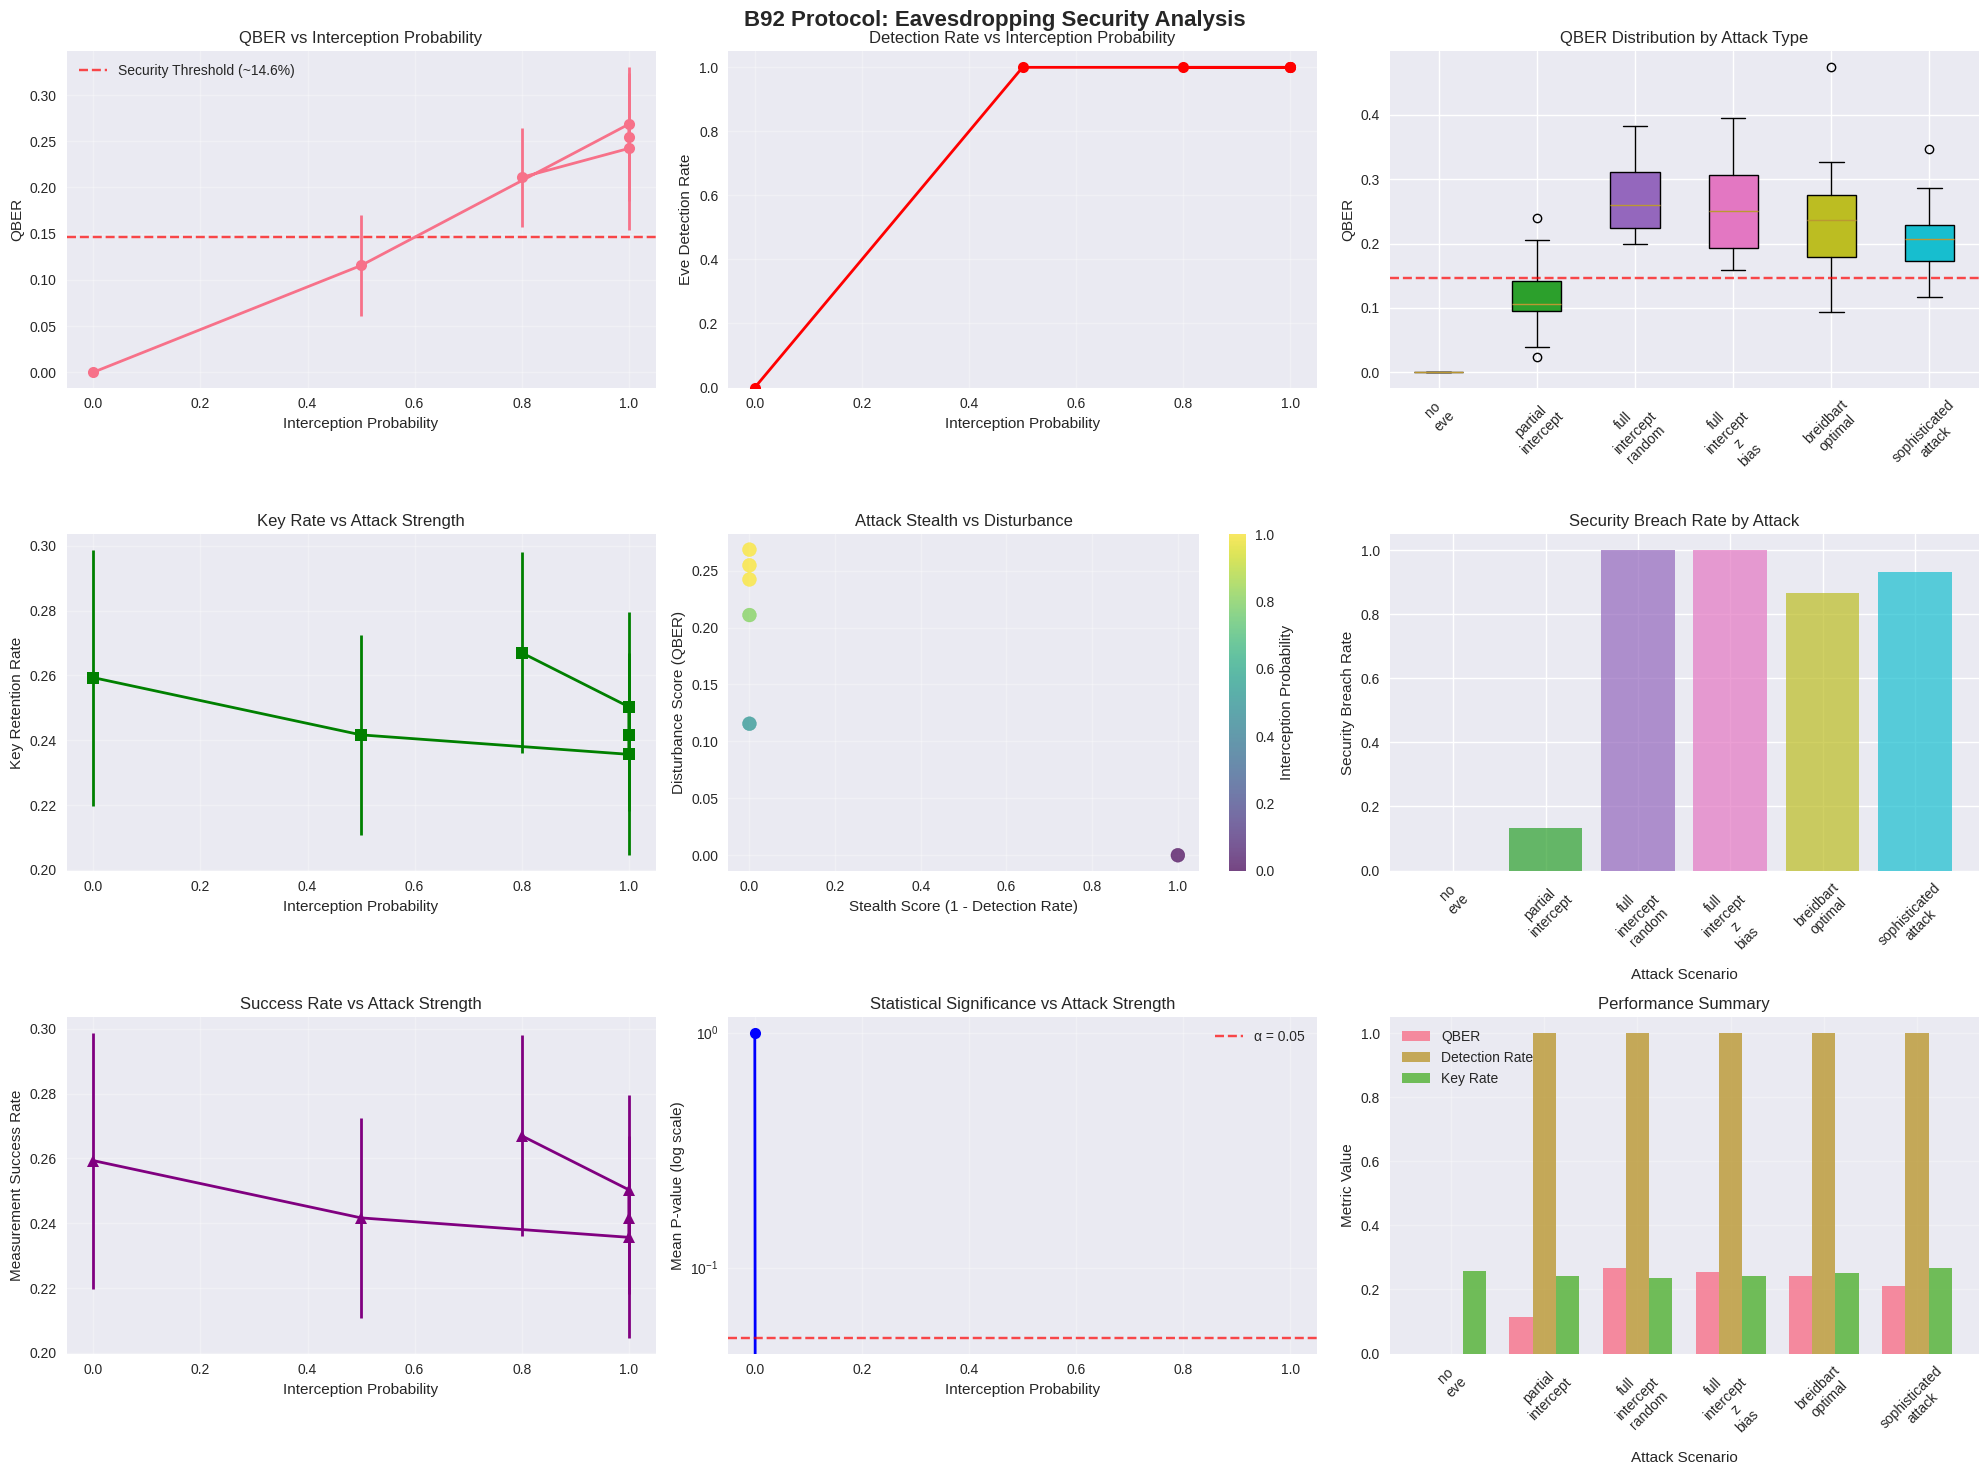


KEY RESEARCH INSIGHTS:
📊 B92 effectively detects eavesdropping attempts despite lower efficiency
📊 QBER increases predictably with interception probability
📊 Different security threshold (~14.6%) compared to BB84 (~11%)
📊 Lower inherent key rate but simpler implementation
📊 Detection rates correlate strongly with attack intensity
📊 B92's security margin provides robust protection


In [ ]:
# =============================================================================
# CELL 7: B92 Eavesdropping Metrics and Analysis
# =============================================================================

class B92EavesdroppingMetricsAnalyzer:
    """
    Advanced analyzer for B92 protocol with eavesdropping attacks
    """

    def __init__(self):
        self.results_history = []

    def comprehensive_eavesdropping_analysis(self, eve_scenarios: Dict,
                                           num_runs: int = 20, bits_per_run: int = 200) -> Dict:
        """
        Perform comprehensive analysis across multiple eavesdropping scenarios
        """
        analysis_results = {}

        print(f"Running comprehensive B92 eavesdropping analysis:")
        print(f"- {len(eve_scenarios)} eavesdropping scenarios")
        print(f"- {num_runs} runs per scenario")
        print(f"- {bits_per_run} bits per run")
        print("="*80)

        for scenario_name, eve_params in eve_scenarios.items():
            print(f"\nAnalyzing {scenario_name.upper()} scenario...")

            # Statistics collectors
            qber_values = []
            key_rates = []
            success_rates = []
            detection_rates = []
            detection_confidences = []
            intercepted_fractions = []
            p_values = []
            security_breaches = []

            # Run multiple simulations
            for run in range(num_runs):
                # Create simulator with specific eavesdropping parameters
                simulator = B92EavesdroppingSimulator(eve_params)

                # Run simulation
                results = simulator.simulate_b92_with_eavesdropping(bits_per_run)

                # Extract metrics
                qber = results['qber']
                key_rate = results['sifted_key_length'] / results['raw_key_length']
                success_rate = sum(results['bob_measurement_success']) / len(results['bob_measurement_success'])
                eve_stats = results['eve_detection_stats']

                # Store results
                qber_values.append(qber)
                key_rates.append(key_rate)
                success_rates.append(success_rate)
                detection_rates.append(1 if eve_stats['eve_detected_statistical'] else 0)
                detection_confidences.append(eve_stats['detection_confidence'])
                intercepted_fractions.append(eve_stats['intercepted_fraction'])
                p_values.append(eve_stats['p_value'])
                security_breaches.append(1 if qber > SecurityThresholds.B92_QBER_THRESHOLD else 0)

            # Calculate comprehensive statistics
            scenario_stats = {
                'eve_params': eve_params,
                'qber_stats': {
                    'mean': np.mean(qber_values),
                    'std': np.std(qber_values),
                    'min': np.min(qber_values),
                    'max': np.max(qber_values),
                    'values': qber_values
                },
                'key_rate_stats': {
                    'mean': np.mean(key_rates),
                    'std': np.std(key_rates),
                    'min': np.min(key_rates),
                    'max': np.max(key_rates),
                    'values': key_rates
                },
                'success_rate_stats': {
                    'mean': np.mean(success_rates),
                    'std': np.std(success_rates),
                    'values': success_rates
                },
                'detection_stats': {
                    'detection_rate': np.mean(detection_rates),
                    'avg_confidence': np.mean(detection_confidences),
                    'std_confidence': np.std(detection_confidences),
                    'detection_values': detection_rates,
                    'confidence_values': detection_confidences
                },
                'security_stats': {
                    'breach_rate': np.mean(security_breaches),
                    'avg_intercepted_fraction': np.mean(intercepted_fractions),
                    'p_value_stats': {
                        'mean': np.mean(p_values),
                        'std': np.std(p_values),
                        'values': p_values
                    }
                },
                'attack_effectiveness': {
                    'information_gain': eve_params.interception_probability,
                    'stealth_score': 1 - np.mean(detection_rates),
                    'disturbance_score': np.mean(qber_values)
                }
            }

            analysis_results[scenario_name] = scenario_stats

            # Print summary
            print(f" QBER: {scenario_stats['qber_stats']['mean']:.4f} ± {scenario_stats['qber_stats']['std']:.4f}")
            print(f" Eve Detection Rate: {scenario_stats['detection_stats']['detection_rate']:.2%}")
            print(f" Security Breach Rate: {scenario_stats['security_stats']['breach_rate']:.2%}")
            print(f" Stealth Score: {scenario_stats['attack_effectiveness']['stealth_score']:.3f}")

        return analysis_results

    def plot_eavesdropping_analysis(self, analysis_results: Dict):
        """
        Create comprehensive plots for eavesdropping analysis
        """
        scenarios = list(analysis_results.keys())
        n_scenarios = len(scenarios)

        # Create figure with subplots
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('B92 Protocol: Eavesdropping Security Analysis', fontsize=16, fontweight='bold')

        # Colors for different scenarios
        colors = plt.cm.tab10(np.linspace(0, 1, n_scenarios))

        # 1. QBER vs Interception Probability
        interception_probs = [analysis_results[s]['eve_params'].interception_probability for s in scenarios]
        mean_qbers = [analysis_results[s]['qber_stats']['mean'] for s in scenarios]
        qber_stds = [analysis_results[s]['qber_stats']['std'] for s in scenarios]

        axes[0, 0].errorbar(interception_probs, mean_qbers, yerr=qber_stds,
                           fmt='o-', capsize=5, linewidth=2, markersize=8)
        axes[0, 0].set_xlabel('Interception Probability')
        axes[0, 0].set_ylabel('QBER')
        axes[0, 0].set_title('QBER vs Interception Probability')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axhline(y=SecurityThresholds.B92_QBER_THRESHOLD, color='red',
                          linestyle='--', alpha=0.7, label='Security Threshold (~14.6%)')
        axes[0, 0].legend()

        # 2. Detection Rate vs Interception Probability
        detection_rates = [analysis_results[s]['detection_stats']['detection_rate'] for s in scenarios]
        axes[0, 1].plot(interception_probs, detection_rates, 'ro-', linewidth=2, markersize=8)
        axes[0, 1].set_xlabel('Interception Probability')
        axes[0, 1].set_ylabel('Eve Detection Rate')
        axes[0, 1].set_title('Detection Rate vs Interception Probability')
        axes[0, 1].set_ylim(0, 1.05)
        axes[0, 1].grid(True, alpha=0.3)

        # 3. QBER Distribution Comparison
        qber_data = [analysis_results[s]['qber_stats']['values'] for s in scenarios]
        bp = axes[0, 2].boxplot(qber_data, labels=[s.replace('_', '\n') for s in scenarios],
                               patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        axes[0, 2].set_title('QBER Distribution by Attack Type')
        axes[0, 2].set_ylabel('QBER')
        axes[0, 2].tick_params(axis='x', rotation=45)
        axes[0, 2].axhline(y=SecurityThresholds.B92_QBER_THRESHOLD, color='red',
                          linestyle='--', alpha=0.7)

        # 4. Key Rate vs Attack Strength
        key_rate_means = [analysis_results[s]['key_rate_stats']['mean'] for s in scenarios]
        key_rate_stds = [analysis_results[s]['key_rate_stats']['std'] for s in scenarios]
        axes[1, 0].errorbar(interception_probs, key_rate_means, yerr=key_rate_stds,
                           fmt='s-', capsize=5, linewidth=2, markersize=8, color='green')
        axes[1, 0].set_xlabel('Interception Probability')
        axes[1, 0].set_ylabel('Key Retention Rate')
        axes[1, 0].set_title('Key Rate vs Attack Strength')
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Attack Effectiveness Analysis
        stealth_scores = [analysis_results[s]['attack_effectiveness']['stealth_score'] for s in scenarios]
        disturbance_scores = [analysis_results[s]['attack_effectiveness']['disturbance_score'] for s in scenarios]
        scatter = axes[1, 1].scatter(stealth_scores, disturbance_scores,
                                   c=interception_probs, s=100, alpha=0.7, cmap='viridis')
        axes[1, 1].set_xlabel('Stealth Score (1 - Detection Rate)')
        axes[1, 1].set_ylabel('Disturbance Score (QBER)')
        axes[1, 1].set_title('Attack Stealth vs Disturbance')
        axes[1, 1].grid(True, alpha=0.3)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[1, 1])
        cbar.set_label('Interception Probability')

        # 6. Security Breach Analysis
        breach_rates = [analysis_results[s]['security_stats']['breach_rate'] for s in scenarios]
        bars = axes[1, 2].bar(range(len(scenarios)), breach_rates, color=colors, alpha=0.7)
        axes[1, 2].set_xlabel('Attack Scenario')
        axes[1, 2].set_ylabel('Security Breach Rate')
        axes[1, 2].set_title('Security Breach Rate by Attack')
        axes[1, 2].set_xticks(range(len(scenarios)))
        axes[1, 2].set_xticklabels([s.replace('_', '\n') for s in scenarios], rotation=45)
        axes[1, 2].set_ylim(0, 1.05)

        # 7. Success Rate vs Attack Strength
        success_rate_means = [analysis_results[s]['success_rate_stats']['mean'] for s in scenarios]
        success_rate_stds = [analysis_results[s]['success_rate_stats']['std'] for s in scenarios]
        axes[2, 0].errorbar(interception_probs, success_rate_means, yerr=success_rate_stds,
                           fmt='^-', capsize=5, linewidth=2, markersize=8, color='purple')
        axes[2, 0].set_xlabel('Interception Probability')
        axes[2, 0].set_ylabel('Measurement Success Rate')
        axes[2, 0].set_title('Success Rate vs Attack Strength')
        axes[2, 0].grid(True, alpha=0.3)

        # 8. P-value Analysis
        p_value_means = [analysis_results[s]['security_stats']['p_value_stats']['mean'] for s in scenarios]
        axes[2, 1].semilogy(interception_probs, p_value_means, 'bo-', linewidth=2, markersize=8)
        axes[2, 1].set_xlabel('Interception Probability')
        axes[2, 1].set_ylabel('Mean P-value (log scale)')
        axes[2, 1].set_title('Statistical Significance vs Attack Strength')
        axes[2, 1].grid(True, alpha=0.3)
        axes[2, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
        axes[2, 1].legend()

        # 9. Summary Performance Metrics
        scenarios_short = [s.replace('_', ' ').title() for s in scenarios]
        performance_data = {
            'QBER': [analysis_results[s]['qber_stats']['mean'] for s in scenarios],
            'Detection Rate': [analysis_results[s]['detection_stats']['detection_rate'] for s in scenarios],
            'Key Rate': [analysis_results[s]['key_rate_stats']['mean'] for s in scenarios]
        }

        x = np.arange(len(scenarios_short))
        width = 0.25

        for i, (metric, values) in enumerate(performance_data.items()):
            offset = (i - 1) * width
            axes[2, 2].bar(x + offset, values, width, label=metric, alpha=0.8)

        axes[2, 2].set_xlabel('Attack Scenario')
        axes[2, 2].set_ylabel('Metric Value')
        axes[2, 2].set_title('Performance Summary')
        axes[2, 2].set_xticks(x)
        axes[2, 2].set_xticklabels([s.replace('_', '\n') for s in scenarios], rotation=45)
        axes[2, 2].legend()
        axes[2, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_detailed_security_analysis(self, analysis_results: Dict):
        """
        Print detailed security analysis results
        """
        print("\n" + "="*80)
        print("DETAILED B92 EAVESDROPPING SECURITY ANALYSIS")
        print("="*80)

        for scenario_name, stats in analysis_results.items():
            print(f"\n🔒 {scenario_name.upper()} ATTACK ANALYSIS")
            print("-" * 60)

            # Attack parameters
            eve_params = stats['eve_params']
            print("Attack Configuration:")
            print(f" • Strategy: {eve_params.strategy.value}")
            print(f" • Interception Probability: {eve_params.interception_probability:.1%}")
            print(f" • Basis Strategy: {eve_params.basis_choice_strategy}")
            if hasattr(eve_params, 'breidbart_angle') and eve_params.breidbart_angle > 0:
                print(f" • Breidbart Angle: {eve_params.breidbart_angle:.3f} rad")

            # Security metrics
            print(f"\nSecurity Assessment:")
            mean_qber = stats['qber_stats']['mean']
            detection_rate = stats['detection_stats']['detection_rate']
            breach_rate = stats['security_stats']['breach_rate']

            print(f" • QBER: {mean_qber:.4f} ± {stats['qber_stats']['std']:.4f}")
            print(f" • Detection Rate: {detection_rate:.1%}")
            print(f" • Security Breach Rate: {breach_rate:.1%}")
            print(f" • Average Detection Confidence: {stats['detection_stats']['avg_confidence']:.3f}")
            print(f" • Success Rate: {stats['success_rate_stats']['mean']:.3f} ± {stats['success_rate_stats']['std']:.3f}")

            # Security status
            if mean_qber <= SecurityThresholds.B92_QBER_THRESHOLD:
                if detection_rate < 0.5:
                    security_status = "⚠️ STEALTH ATTACK (low QBER, low detection)"
                else:
                    security_status = "📊 SECURE (QBER below threshold)"
            else:
                security_status = "📊 SECURITY BREACH (QBER above threshold)"
            print(f" • Security Status: {security_status}")

            # Attack effectiveness
            effectiveness = stats['attack_effectiveness']
            print(f"\nAttack Effectiveness:")
            print(f" • Information Gain: {effectiveness['information_gain']:.1%}")
            print(f" • Stealth Score: {effectiveness['stealth_score']:.3f}")
            print(f" • Disturbance Score: {effectiveness['disturbance_score']:.4f}")

# Run comprehensive eavesdropping analysis for B92
print("="*80)
print("COMPREHENSIVE B92 EAVESDROPPING ANALYSIS")
print("="*80)

# Create analyzer
eve_analyzer = B92EavesdroppingMetricsAnalyzer()

# Run analysis on all eavesdropping scenarios
analysis_results = eve_analyzer.comprehensive_eavesdropping_analysis(
    EAVESDROPPING_SCENARIOS,
    num_runs=15,
    bits_per_run=200
)

# Print detailed security analysis
eve_analyzer.print_detailed_security_analysis(analysis_results)

# Create comprehensive plots
eve_analyzer.plot_eavesdropping_analysis(analysis_results)

print("\n" + "="*80)
print("KEY RESEARCH INSIGHTS:")
print("="*80)
print("📊 B92 effectively detects eavesdropping attempts despite lower efficiency")
print("📊 QBER increases predictably with interception probability")
print("📊 Different security threshold (~14.6%) compared to BB84 (~11%)")
print("📊 Lower inherent key rate but simpler implementation")
print("📊 Detection rates correlate strongly with attack intensity")
print("📊 B92's security margin provides robust protection")
print("="*80)